# DSCI 100 Group Project Final Report
## Introduction:
- provide some relevant background information on the topic so that someone unfamiliar with it will be prepared to understand the rest of your report
- clearly state the question you tried to answer with your project - **already done**
- identify and fully describe the dataset that was used to answer the question - **already done**

### Summary of Data Description
- TODO

## Methods & Results:
- describe the methods you used to perform your analysis from beginning to end that narrates the analysis code.
your report should include code which:
    - 1. loads data  - **already done**
    - 2. wrangles and cleans the data to the format necessary for the planned analysis - **already done**
    - 3. performs a summary of the data set that is relevant for exploratory data analysis related to the planned analysis - **already done**
    - 4. creates a visualization of the dataset that is relevant for exploratory data analysis related to the planned analysis - **already done**
    - **5. performs the data analysis**
    - **6. creates a visualization of the analysis** 
    - **note:** all figures should have a figure number and a legend

In [1]:
# Load libraries needed
library(tidyverse)
library(repr)
library(tidymodels)

# Load dataset
players <- read_csv("https://raw.githubusercontent.com/nesteagle/DSCI100-Project/refs/heads/main/data/players.csv")
sessions <- read_csv("https://raw.githubusercontent.com/nesteagle/DSCI100-Project/refs/heads/main/data/sessions.csv")

# Rename columns for consistency
players <- players |>
    rename(age = Age, hashed_email = hashedEmail)
sessions <- sessions |>
    rename(hashed_email = hashedEmail)

# set seed for reproducibility?
set.seed(100)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


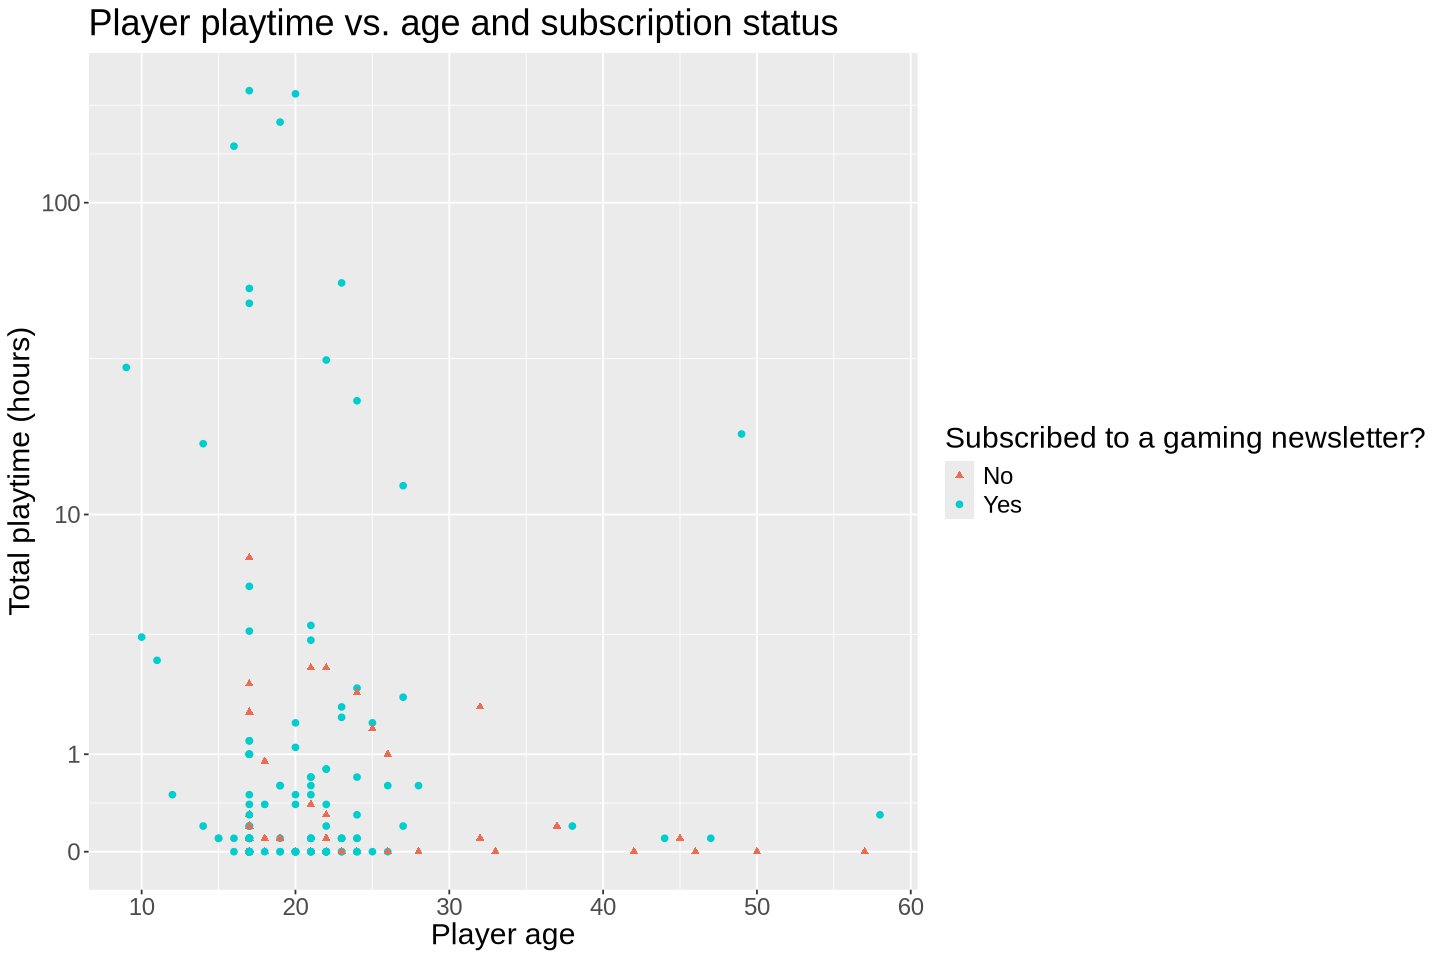

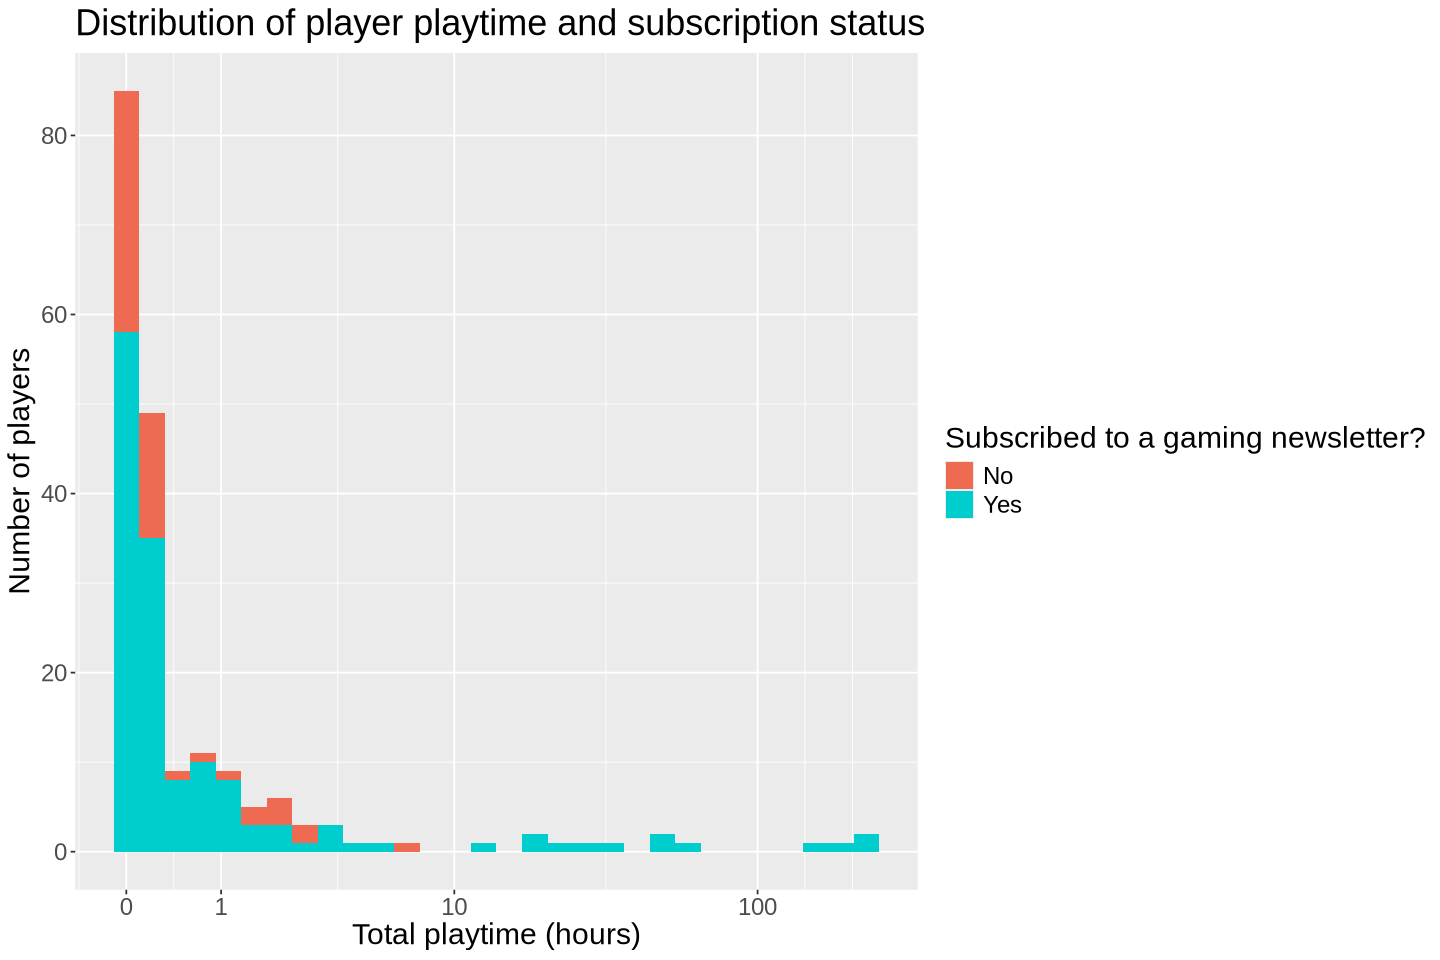

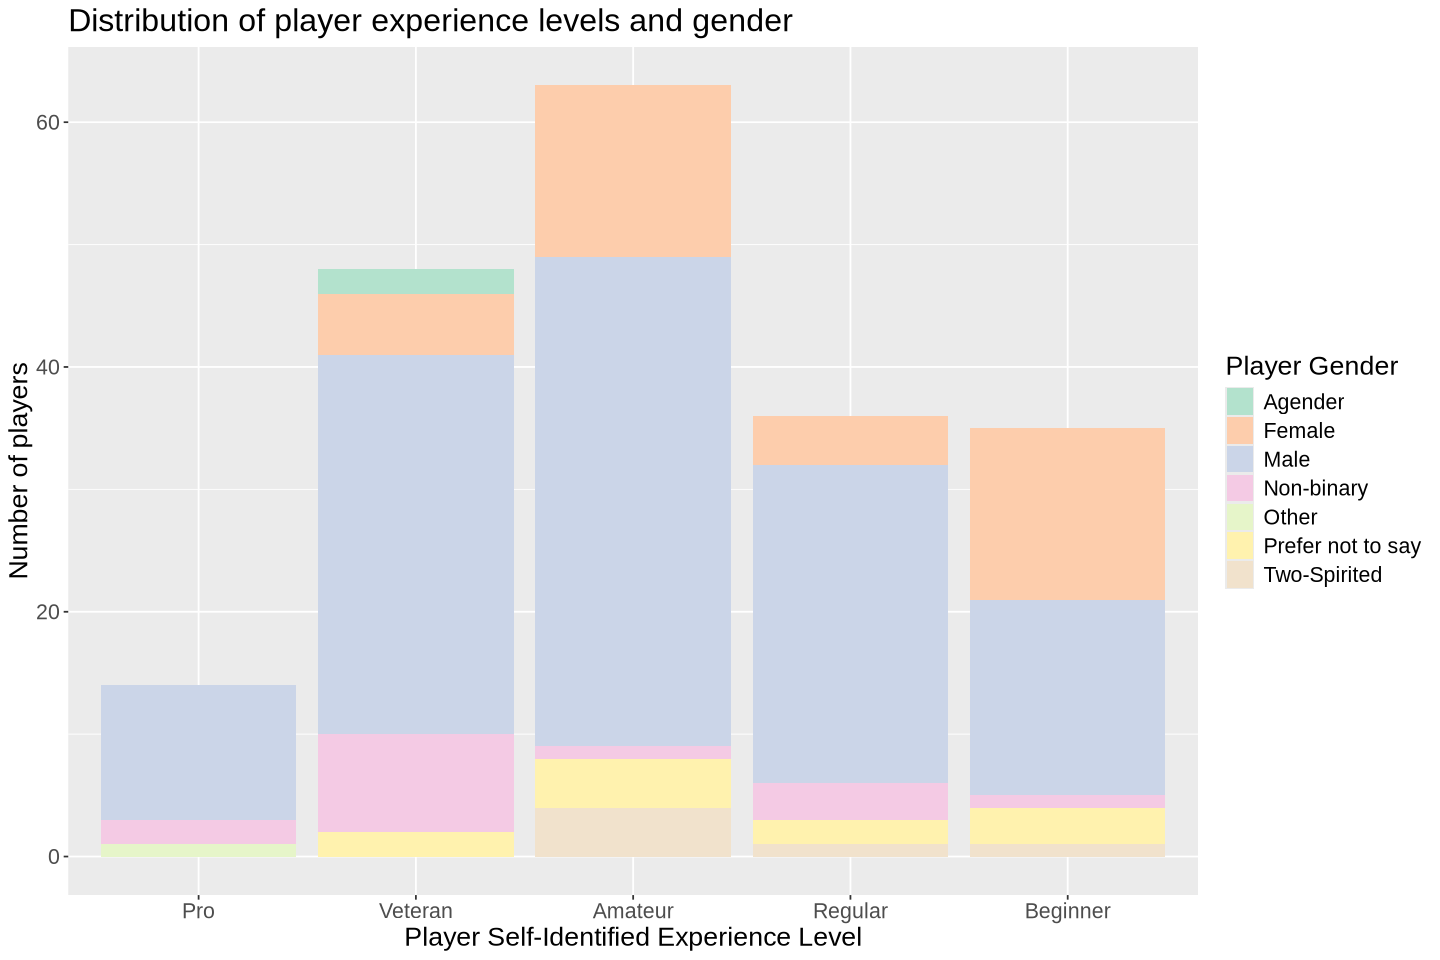

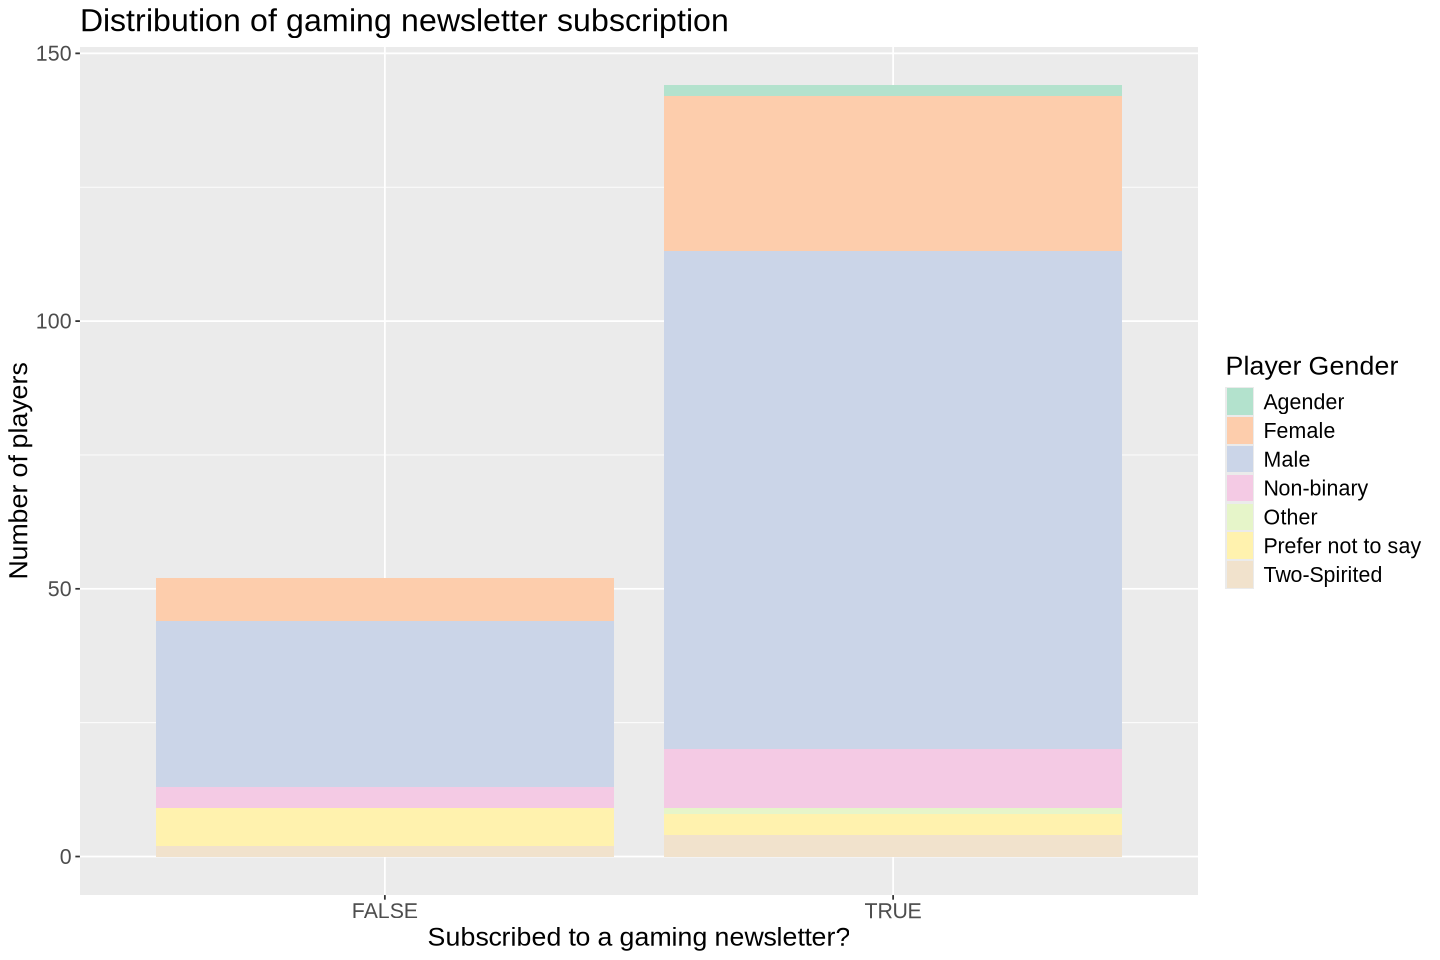

In [2]:
library(RColorBrewer)
options(repr.plot.width = 12, repr.plot.height = 8)

players_shifted <- players |> 
    mutate(played_hours = played_hours + 1)

ggplot(players_shifted, aes(x=age, y=played_hours, colour = subscribe, shape = subscribe)) +
    geom_point() +
    labs(x="Player age", y="Total playtime (hours)", colour = "Subscribed to a gaming newsletter?", shape = "Subscribed to a gaming newsletter?", title="Player playtime vs. age and subscription status")+
    scale_color_manual(labels=c("No","Yes"), values=c("coral2", "cyan3"))+
    scale_shape_manual(labels=c("No","Yes"), values=c("triangle", "circle"))+
    scale_y_log10(breaks=c(1,2,11,101), labels=c("0","1","10","100"))+
    theme(text = element_text(size=18))

ggplot(players_shifted, aes(x=played_hours, fill = subscribe)) +
    geom_histogram() +
    labs(x="Total playtime (hours)", y="Number of players", fill = "Subscribed to a gaming newsletter?", title="Distribution of player playtime and subscription status")+
    scale_fill_manual(labels=c("No","Yes"), values=c("coral2", "cyan3"))+
    theme(text = element_text(size=18))+
    scale_x_log10(breaks=c(1,2,11,101), labels=c("0","1","10","100"))

ggplot(players, aes(x=as_factor(experience), fill = gender)) +
    geom_bar(stat="count") +
    theme(text = element_text(size=16)) +
    labs(x="Player Self-Identified Experience Level", y="Number of players", title="Distribution of player experience levels and gender", fill = "Player Gender")+
    scale_fill_brewer(palette = 'Pastel2')

ggplot(players, aes(x=subscribe, fill=gender)) + 
    geom_bar(stat="count") +
    theme(text = element_text(size=16)) +
    labs(x="Subscribed to a gaming newsletter?", y="Number of players", title="Distribution of gaming newsletter subscription", fill = "Player Gender")+
    scale_fill_brewer(palette = 'Pastel2')

In [11]:
# MD cell to go above

set.seed(2025)

# split into testing, training sets
players_factor <- mutate(players, subscribe = as_factor(subscribe))
players_split <- initial_split(players_factor, prop = 0.7, strata = played_hours)
players_train <- training(players_split)
players_test <- testing(players_split)

# possibly revise EDA to include logtransformed regression
players_recipe <- recipe(played_hours ~ subscribe+age+gender+experience, data = players_train) |>
    step_scale(age) |>
    step_center(age)

players_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("regression")

players_vfold <- vfold_cv(players_train, v = 5, strata = played_hours)

players_workflow <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(players_spec) |>
    fit(players_factor)

players_workflow

gridvals <- tibble(neighbors = seq(from = 1, to = 25, by = 1))

players_results <- players_workflow |>
    tune_grid(resamples = players_vfold, grid = gridvals) |>
    collect_metrics() |>
    filter(.metric == "rmse")

players_results
rmse_min <- players_results |>
    slice_min(std_err, n=1)
rmse_min 

Warning message:
“tune samples were requested but there were 196 rows in the data. 191 will be used.”


══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(tune(),     data, 5), kernel = ~"rectangular")

Type of response variable: continuous
minimal mean absolute error: 10.24354
Minimal mean squared error: 811.6846
Best kernel: rectangular
Best k: 191

→ A | error:   Assigned data `orig_rows` must be compatible with existing data.
               ✖ Existing data has 27 rows.
               ✖ Assigned data has 28 rows.
               ℹ Only vectors of size 1 are recycled.
               Caused by error in `vectbl_recycle_rhs_rows()`:
               ! Can't recycle input of size 28 to size 27.

There were issues with some computations   A: x1

There were issues with some computations   A: x1





neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,rmse,standard,29.06291,4,12.09076,Preprocessor1_Model01
2,rmse,standard,28.68370,4,12.18998,Preprocessor1_Model02
3,rmse,standard,29.87335,4,12.07436,Preprocessor1_Model03
4,rmse,standard,29.66133,4,12.02209,Preprocessor1_Model04
5,rmse,standard,29.81768,4,11.82489,Preprocessor1_Model05
6,rmse,standard,29.47225,4,11.95715,Preprocessor1_Model06
7,rmse,standard,30.49597,4,11.50988,Preprocessor1_Model07
8,rmse,standard,30.02846,4,11.67888,Preprocessor1_Model08
9,rmse,standard,30.60180,4,11.31094,Preprocessor1_Model09


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
10,rmse,standard,29.65344,4,10.9653,Preprocessor1_Model10


## Discussion:
- summarize what you found
- discuss whether this is what you expected to find
- discuss what impact could such findings have
- discuss what future questions could this lead to
## References
references if necessary, make sure they all have a consistent citation style.